In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle
from odc.stac import configure_rio, load as odc_load
from pystac_client import Client as pystacClient
from dask_jobqueue import SLURMCluster
from dask.distributed import Client as daskClient
from dask import compute as dask_compute
from zarr.errors import ContainsGroupError
from xarray import open_zarr as xr_open_zarr
from shapely.geometry import box as s_box

from stacathome.walltowall import *

configure_rio(cloud_defaults=True, aws={"aws_unsigned": True})

In [133]:
# make one class that does all the things
import dask.backends
import dask.bag
from tqdm import tqdm
from urllib.request import urlretrieve
import dask
from functools import partial
from itertools import chain
import dask.bag as db

class MaxiCube:

    def __init__(self, aoi, crs=4326, resolution=0.00018, 
                 chunksize_xy=256, 
                 chunksize_t=-1, 
                 path=None,
                 url=None,
                 collection='sentinel-2-l2a',
                 requested_bands=None,
                 save_name='stacathome_local_items.pkl'):
        # manage data structure
        aoi, self.name = get_aoi_and_name(aoi)
        self.crs = crs
        self.resolution = resolution
        self.chunksize_xy = chunksize_xy
        self.chunksize_t = chunksize_t
        self.geobox, self.aoi = get_geobox_from_aoi(aoi, self.crs, self.resolution, self.chunksize_xy, return_aoi=True)
        self.chunk_table = chunk_table_from_geobox(self.geobox, self.chunksize_xy, self.aoi)
        if not requested_bands:
            self.requested_bands = ['B02', 'B03', 'B04', 'B8A']
        else:
            self.requested_bands = requested_bands

        # manage data assets
        if not url:
            self.url = "https://planetarycomputer.microsoft.com/api/stac/v1"
        else:
            self.url = url
        self.collection = collection
        
        self.path = path
        self.save_name = save_name
        if self.path:
            self.items_local_global = self.local_assets()
        else:    
            self.items_local_global = None
        self.req_items = None
        self.pending = None
        self.req_items_local = None
    
    def plot_chunk_table(self):
        return self.chunk_table.plot(column='chunk_id', cmap='viridis', legend=True, markersize=.05)
    
    def subset(self, chunk_id=None, lat_lon=None, enlarge_by_n_chunks=0):
        if chunk_id is not None:
            subset, yx_index_slices = subset_geobox_by_chunk_nr(self.geobox, chunk_id, self.chunksize_xy, 
                                                                self.chunk_table, enlarge_by_n_chunks)
        elif lat_lon is not None:
            subset, yx_index_slices = subset_geobox_by_chunks_latlon(self.geobox, lat_lon[0], lat_lon[1], 
                                                                     self.chunksize_xy, 
                                                                     self.chunk_table, 
                                                                     enlarge_by_n_chunks)
        else:
            raise ValueError('Must provide either chunk_id or lat_lon')
        return subset, yx_index_slices
    
    def request_items(self, start_date, end_date,
                      subset, enlarge_by_n_chunks=0,
                      collection=None, url=None):
        if subset is None and subset == 'full':
            subset = self.aoi
            print('Using full aoi this may take a while')
        elif isinstance(subset, int):
            subset, _ = self.subset(chunk_id=subset, 
                                    enlarge_by_n_chunks=enlarge_by_n_chunks)
            subset = s_box(*subset.boundingbox)
        elif isinstance(subset, tuple):
            subset, _ = self.subset(lat_lon=subset, 
                                    enlarge_by_n_chunks=enlarge_by_n_chunks)
            subset = s_box(*subset.boundingbox)

        if not collection:
            collection = self.collection
        else:
            raise UserWarning('Using collection defined in function call - may differ from init')
        if not url:
            url = self.url
        else:
            raise UserWarning('Using url defined in function call - may differ from init')
        # catalog setup
        catalog = pystacClient.open(url)
        self.req_items = catalog.search(
            intersects=subset,
            datetime=f"{start_date}/{end_date}",
            collections=[collection],
        ).item_collection()
        self.compare_local(report=True)

    
    def compare_local(self, report=False):
        if not self.req_items:
            raise ValueError('Request items first')
        self.req_items_local, self.pending = check_request_against_local(self.req_items, self.path,
                                                       requested_bands=self.requested_bands, report=report)
    
    def local_assets(self, rerequest=False):
        if not rerequest or os.path.exists(os.path.join(self.path, self.save_name)):
            return pickle.load(open(os.path.join(self.path, self.save_name), 'rb'))
        return get_all_local_assets(self.path, self.collection, self.requested_bands) 
    
    def plot(self, items=None, plot_chunks=True, subset_chunks_by=50):
        # ENH: add option to plot requested/avail items
        if not items:
            items = self.items_local_global
        if plot_chunks:
            return leaflet_overview(items, self.chunk_table.iloc[::subset_chunks_by], self.aoi)
        else:
            return leaflet_overview(items, aoi=self.aoi)
    
    def download(self, items=None, use_dask=True, daskkwargs={}):        
        if not items:
            if not self.req_items:
                raise ValueError('Request items first, or provide items to the download function')
            items = self.req_items
        else:
            raise UserWarning('Using items defined in function call - may differ from request')
        
        self.compare_local(report=False)
        
        if len(self.pending) ==0 :
            print('All items already downloaded')
            return 
        
        if use_dask:
            # Create a SLURM cluster
            cluster = SLURMCluster(
                queue=daskkwargs['queue'] if 'queue' in daskkwargs else 'work', 
                cores=daskkwargs['cores'] if 'cores' in daskkwargs else 1,                        
                memory=daskkwargs['memory'] if 'memory' in daskkwargs else '500MB',                 
                walltime=daskkwargs['walltime'] if 'walltime' in daskkwargs else '03:00:00',       
            )

            if 'min_workers' in daskkwargs and 'max_workers' in daskkwargs:
                cluster.adapt(minimum=daskkwargs['min_workers'], maximum=daskkwargs['max_workers'])
            elif 'num_workers' in daskkwargs:
                cluster.scale(jobs=daskkwargs['num_workers'])
            else:
                cluster.adapt(minimum=1, maximum=20)

            # Create a Dask client that connects to the cluster
            client = daskClient(cluster)

            # Check cluster status
            print(cluster)

            tasks = [dask.delayed(get_asset(*i)) for i in self.pending]

            if len(tasks) > 10000000:
                # https://docs.dask.org/en/stable/delayed-best-practices.html
                print('many tasks consider dask.bag')

            job_results = dask_compute(*tasks)

            client.close()
            cluster.close()

            to_pop = []
            for i, j in enumerate(job_results):
                if j == None:
                    to_pop.append(i)
            for i in to_pop[::-1]:
                self.pending.pop(i)

            if len(self.pending) == 0:
                return 'All items downloaded'
   
        else:
            for i in tqdm(self.pending):
                get_asset(*i)

    def merge_items(self, items=None):
        if not items:
            if not self.req_items_local:
                raise ValueError('Request and download items first!')
            items = self.req_items_local
        for i in self.req_items_local:
            if i not in self.items_local_global:
                self.items_local_global.append(i)
            else:
                idx = self.items_local_global.index(i)
                for band in i.assets:
                    if band not in self.items_local_global[idx].assets:
                        self.items_local_global[idx].assets[band] = i.assets[band]

    def save_items(self, items=None):
        if not items:
            if not self.req_items:
                raise ValueError('Request and download items first!')
            items = self.req_items
        elif isinstance(items, list):
            self.req_items = self.get_unique_elements(items)

        self.compare_local(report=False)
        self.merge_items()

        with open(os.path.join(self.path, self.save_name), 'wb') as f:
            pickle.dump(self.items_local_global, f)

    def parallel_request(self, start_date, end_date):

        # determine maximum edges
        lonmin, latmin, lonmax, latmax = self.aoi.bounds

        resolution = .8  # ~90 km, should catch most S2 tiles of 110x110 km
        X,Y = np.meshgrid(np.arange(latmin, latmax, resolution),
                    np.arange(lonmin, lonmax, resolution))

        points = list(zip(Y.flatten(), X.flatten()))

        process = [(point) for point in points if self.aoi.contains(Point(*point))]

        request_partial = partial(self.request_items_parallel, start_date=start_date, 
                                  end_date=end_date, collection=self.collection, url=self.url)
        dask_bag = db.from_sequence(process).map(request_partial)
        items = dask_bag.compute()

        return items
    
    def check_parallel_request(self, items):
        unique = self.get_unique_elements(items)
        _, filtered_requests = check_request_against_local(unique, out_path=self.path, 
                                                           requested_bands=self.requested_bands)
        return filtered_requests

    def parallel_download(self, items):
        downloads = db.from_sequence(items).map(self.download_item)
        downloads.compute()
    
    @staticmethod
    def download_item(item):
        return get_asset(*item)

    @staticmethod
    def get_unique_elements(lists_of_objects):
        # Flatten the list of lists and use a set to get unique elements
        merged_list = list(chain(*lists_of_objects))
        return list(set(merged_list))

    @staticmethod
    def request_items_parallel(lon_lat, start_date, end_date, url, collection):
        catalog = pystacClient.open(url)
        return catalog.search(intersects=Point(lon_lat[0], lon_lat[1]),
                                datetime=f"{start_date}/{end_date}",
                                collections=[collection],
                                ).item_collection()
            
    


In [134]:
    
        
aoi='somalia'
requested_bands = ['B02', 'B03', 'B04', 'B8A']
resolution = 0.00018
chunksize_xy = 256

mxc = MaxiCube(aoi=aoi,
            requested_bands=requested_bands,
            crs=4326,
            resolution=resolution,
            chunksize_xy=chunksize_xy,
            path='/Net/Groups/BGI/data/DataStructureMDI/DATA/Incoming/Sentinel/_2/S2A_L2A/ForSites/Sentinel2tiles'
            
            )


# todo: merge local items with requested items

# make a walker that can walk through the chunks, requests items and downloads them

In [87]:
cluster = SLURMCluster(
    queue='work',                  # Specify the SLURM queue
    cores=1,                          # Number of cores per job
    memory='768MB',                    # Memory per job
    walltime='03:00:00',              # Job duration (hh:mm:ss)
)

# Scale up the number of workers
# cluster.scale(jobs=8)  # Adjust the number of jobs/workers
cluster.adapt(minimum=1, maximum=20)

# Create a Dask client that connects to the cluster
client = daskClient(cluster)

# Check cluster status
cluster

/User/homes/mzehner/micromamba/envs/stacathome/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46379 instead
  warnings.warn(


Dashboard: http://10.0.30.56:46379/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.30.56:37467,Workers: 0
Dashboard: http://10.0.30.56:46379/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [92]:
process = mxc.parallel_request('2021-01-01', '2021-01-31')

In [124]:
checked = mxc.check_parallel_request(process)

In [ ]:
mxc.parallel_download(checked)

In [135]:
mxc.save_items(process)

True

In [86]:
client.close()
cluster.close()

In [136]:
mxc.plot()

In [170]:
mxc.request_items('2021-01-01', '2021-01-31', subset=0)

All data already downloaded.


In [171]:
mxc.save_items()

In [5]:
all_local_avail_items = get_all_local_assets('/Net/Groups/BGI/data/DataStructureMDI/DATA/Incoming/Sentinel/_2/S2A_L2A/ForSites/Sentinel2tiles')

In [10]:
len(all_local_avail_items)
with open(os.path.join('/Net/Groups/BGI/data/DataStructureMDI/DATA/Incoming/Sentinel/_2/S2A_L2A/ForSites/Sentinel2tiles','stacathome_local_items.pkl'), 'wb') as f:
    pickle.dump(all_local_avail_items, f)

# General Setup

In [2]:


  # ~20m resolution
# resolution_in_utm = 20  # just used for approx. subsetting


# define subset to process now
lat = 47.3  # 40.9974
lon = 10.7  # 2.5856 
subset_size = 510
start_date = '2016-01-01'
end_date = '2016-01-31'



# Setup the geobox for the whole study area
This example uses the whole of Somalia to create a Geobox of regular 0.00018 ~20m grid.

In [3]:
#aoi_shape = get_countries_json('somalia')
#type(aoi_shape)

dict

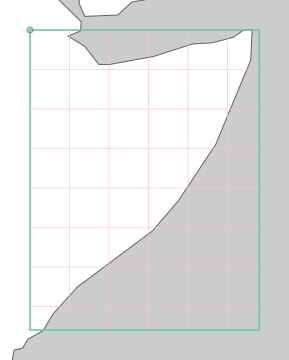

In [4]:
#epsg = 4326
# create a geobox for consistent spatial reference
#geobox, aoi = get_geobox_from_aoi(aoi_shape, epsg, resolution, chunksize_xy, return_aoi=True)
#geobox

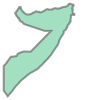

In [5]:
#aoi

In [6]:
#ch_table = chunk_table_from_geobox(geobox, chunksize_xy, aoi)
#ch_table.head(), ch_table.tail()

(   lon_chunk  lat_chunk  lon_coord  lat_coord                   geometry  \
 0        128      54400   50.77458   11.99196  POINT (50.77458 11.99196)   
 1        128      54656   50.82066   11.99196  POINT (50.82066 11.99196)   
 2        384      53376   50.59026   11.94588  POINT (50.59026 11.94588)   
 3        384      53632   50.63634   11.94588  POINT (50.63634 11.94588)   
 4        384      53888   50.68242   11.94588  POINT (50.68242 11.94588)   
 
    chunk_id  
 0         0  
 1         1  
 2         2  
 3         3  
 4         4  ,
        lon_chunk  lat_chunk  lon_coord  lat_coord                   geometry  \
 24846      75392       3200   41.55858   -1.55556  POINT (41.55858 -1.55556)   
 24847      75392       3456   41.60466   -1.55556  POINT (41.60466 -1.55556)   
 24848      75392       3712   41.65074   -1.55556  POINT (41.65074 -1.55556)   
 24849      75648       3200   41.55858   -1.60164  POINT (41.55858 -1.60164)   
 24850      75648       3456   41.60466 

<Axes: >

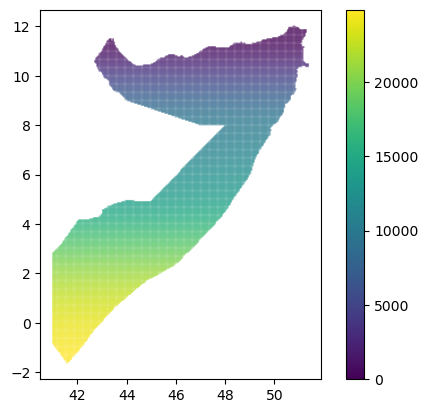

In [7]:
#ch_table.plot(column='chunk_id', cmap='viridis', legend=True, markersize=.05)

# Define one minicube as area to download now, see if there is already data locally
The data is requested from planetarycomputers, the subset is an example, we could ask for all scenes in the aoi at once by switching out geobox_subset.

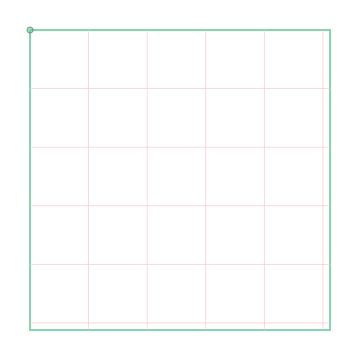

In [8]:
# geobox_subset, yx_index_slices = subset_geobox_by_chunk_nr(geobox, 21889, chunksize_xy, ch_table)
# # alterantively:
# # geobox_subset, yx_index_slices = subset_geobox_by_chunks_latlon(geobox, lat, lon, chunksize_xy, ch_table, enlarge_by_x_chunks=100)
# geobox_subset

In [9]:
# catalog setup
# stac = "https://planetarycomputer.microsoft.com/api/stac/v1"
# catalog = pystacClient.open(stac)  #, modifier=pc.sign_inplace)  # sign in place might get stale for longer processes
# collection = 'sentinel-2-l2a'

# items = catalog.search(
#     intersects=geobox_subset.geographic_extent,
#     datetime=f"{start_date}/{end_date}",
#     collections=[collection],
# ).item_collection()
# len(items)

5

In [10]:
# storage space
out_path = '/Net/Groups/BGI/data/DataStructureMDI/DATA/Incoming/Sentinel/_2/S2A_L2A/ForSites/Sentinel2tiles'
os.makedirs(out_path, exist_ok=True)

In [11]:
avail_items, to_download = check_request_against_local(items, out_path,
                                                       requested_bands=requested_bands)

11 missing assets of 3 items to download.


# Download the tiles, write new asset metadata and make cube from local data.

In [12]:
if len(to_download) > 0:
    # Create a SLURM cluster
    cluster = SLURMCluster(
        queue='work',                  # Specify the SLURM queue
        cores=1,                          # Number of cores per job
        memory='500MB',                    # Memory per job
        walltime='03:00:00',              # Job duration (hh:mm:ss)
    )

    # Scale up the number of workers
    # cluster.scale(jobs=8)  # Adjust the number of jobs/workers
    cluster.adapt(minimum=1, maximum=20)

    # Create a Dask client that connects to the cluster
    client = daskClient(cluster)

    # Check cluster status
    cluster

/User/homes/mzehner/micromamba/envs/stacathome/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43017 instead
  warnings.warn(


In [13]:
if len(to_download) > 0:
    tasks = [get_asset(*i) for i in to_download]
    len(tasks)

In [14]:
if len(to_download) > 0:
    _ = dask_compute(*tasks)

In [15]:
if len(to_download) > 0:
    client.close()
    cluster.close()

# Get overview of the available data

In [16]:
all_local_avail_items = get_all_local_assets(out_path)

In [17]:
with open(os.path.join(out_path,'/all_local_avail_items.pkl'), 'wb') as f:
    pickle.dump(all_local_avail_items, f)


In [ ]:
leaflet_overview(pickle.load(open('all_local_avail_items.pkl', 'rb')), ch_table.iloc[::50])

# Load the requested data as xarray

In [19]:
ds_odc = odc_load(
    all_local_avail_items,
    bands=requested_bands,
    chunks={'time': -1, 'x': chunksize_xy, 'y': chunksize_xy},
    geobox=geobox_subset,
    dtype='uint16',
    resampling='bilinear',
    groupby='solar_day',
)
ds_odc

<xarray.Dataset> Size: 126MB
Dimensions:      (latitude: 256, longitude: 256, time: 241)
Coordinates:
  * latitude     (latitude) float64 2kB 1.601 1.601 1.6 ... 1.555 1.555 1.555
  * longitude    (longitude) float64 2kB 41.07 41.08 41.08 ... 41.12 41.12 41.12
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 2kB 2016-01-02T07:42:42.030000 ... 202...
Data variables:
    B02          (time, latitude, longitude) uint16 32MB dask.array<chunksize=(241, 256, 256), meta=np.ndarray>
    B03          (time, latitude, longitude) uint16 32MB dask.array<chunksize=(241, 256, 256), meta=np.ndarray>
    B04          (time, latitude, longitude) uint16 32MB dask.array<chunksize=(241, 256, 256), meta=np.ndarray>
    B8A          (time, latitude, longitude) uint16 32MB dask.array<chunksize=(241, 256, 256), meta=np.ndarray>

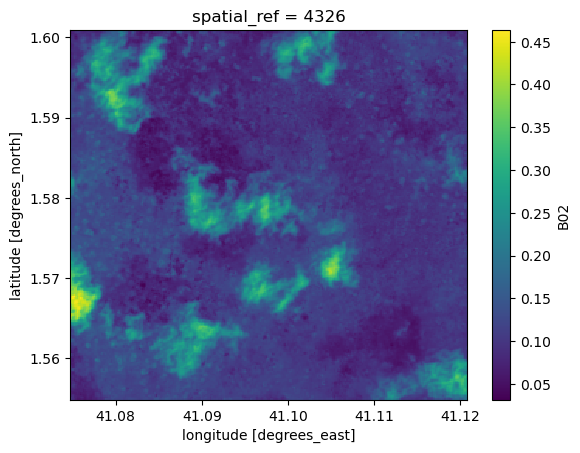

In [20]:
#ds_odc.isel(time=-1, latitude=slice(100,200), longitude=slice(100,200)).B02.plot.imshow()
(ds_odc.B02.where(ds_odc.B02 != 0, np.nan).median(dim='time')/10000).plot()

# Prepare to insert data into a larger consistent cube

In [21]:
# setup for large datacube
zarr_store = '/Net/Groups/BGI/scratch/mzehner/VCI_Somalia/Somalia_S2_2014_2026_dask_test.zarr'
chunksize_xy = 256
time_chunk_size = -1
requested_bands = ['B02', 'B03', 'B04', 'B8A']
start_date_zarr = '2014-01-01'
end_date_zarr = '2026-12-31'
# create an empty zarr file with the correct geobox
try:
    create_skeleton_zarr(geobox, zarr_store, 
                         chunksize_xy=chunksize_xy, 
                         time_chunk_size=time_chunk_size, 
                         dtype=np.uint16, 
                         bands=requested_bands, 
                         start_date=start_date_zarr, 
                         end_date=end_date_zarr, 
                         t_freq='1D',
                         overwrite=False)
except ContainsGroupError as e:
    print(f'Zarr already exists at {zarr_store}. Skipping creation.')

Zarr already exists at /Net/Groups/BGI/scratch/mzehner/VCI_Somalia/Somalia_S2_2014_2026_dask_test.zarr. Skipping creation.


In [22]:
ds_odc = odc_load(
    all_local_avail_items,
    bands=requested_bands,
    chunks={'time': -1, 'x': chunksize_xy, 'y': chunksize_xy},
    geobox=geobox_subset,
    dtype='uint16',
    resampling='bilinear',
    groupby='solar_day'
)
ds_odc = ds_odc.drop_vars(['spatial_ref'])
ds_odc['time'] = ds_odc.time.dt.floor('D')

In [23]:
min_time = ds_odc['time'].min().values
max_time = ds_odc['time'].max().values

t_start = (min_time - pd.to_datetime(start_date_zarr).to_numpy()).astype('timedelta64[D]').astype(int)
t_end = (max_time - pd.to_datetime(start_date_zarr).to_numpy()).astype('timedelta64[D]').astype(int)

if time_chunk_size > 0:
    print('Reindexing time dimension to match chunk size')
    t_start = t_start//time_chunk_size * time_chunk_size
    t_end = ((t_end//time_chunk_size)+1) * time_chunk_size
   
    t_reindex_start = start_date_zarr
    t_reindex_end = end_date_zarr
else:
    t_end += 1
    t_reindex_start = min_time
    t_reindex_end = max_time

t_index_slices = (t_start, t_end)
 

# reindex for consistent chunk dimensions, maybe there is a better way to do this
ds_odc = (ds_odc.reindex(time=pd.date_range(t_reindex_start, t_reindex_end, freq='1D'), 
                        fill_value=0, method='nearest')
                .chunk({'time': time_chunk_size, 
                        'latitude': chunksize_xy, 
                        'longitude': chunksize_xy}
                        )
        )
if time_chunk_size > 0:
        ds_odc = ds_odc.isel(time=slice(*t_index_slices))
ds_odc

<xarray.Dataset> Size: 2GB
Dimensions:    (latitude: 256, longitude: 256, time: 3165)
Coordinates:
  * latitude   (latitude) float64 2kB 1.601 1.601 1.6 1.6 ... 1.555 1.555 1.555
  * longitude  (longitude) float64 2kB 41.07 41.08 41.08 ... 41.12 41.12 41.12
  * time       (time) datetime64[ns] 25kB 2016-01-02 2016-01-03 ... 2024-08-31
Data variables:
    B02        (time, latitude, longitude) uint16 415MB dask.array<chunksize=(3165, 256, 256), meta=np.ndarray>
    B03        (time, latitude, longitude) uint16 415MB dask.array<chunksize=(3165, 256, 256), meta=np.ndarray>
    B04        (time, latitude, longitude) uint16 415MB dask.array<chunksize=(3165, 256, 256), meta=np.ndarray>
    B8A        (time, latitude, longitude) uint16 415MB dask.array<chunksize=(3165, 256, 256), meta=np.ndarray>

# Save the current cube into large dataset

In [24]:
tasks = []
for b in requested_bands:
    for x in range(0, len(ds_odc.longitude), chunksize_xy):
        for y in range(0, len(ds_odc.latitude), chunksize_xy):
            tasks.append(store_chunks_to_zarr(ds_odc, zarr_store, b, t_index_slices, yx_index_slices, chunksize_xy, x, y))

In [25]:
# Create a SLURM cluster
# Create a SLURM cluster
cluster = SLURMCluster(
    queue='work',                  # Specify the SLURM queue
    cores=1,                          # Number of cores per job
    memory='32GB',                    # Memory per job
    walltime='03:00:00',              # Job duration (hh:mm:ss)
)

# Scale up the number of workers
# cluster.scale(jobs=8)  # Adjust the number of jobs/workers
cluster.adapt(minimum=1, maximum=20)

# Create a Dask client that connects to the cluster
client = daskClient(cluster)

# Check cluster status
cluster
# # Create delayed tasks
# tasks = [fixed_function(i) for i in requested_bands]
# Trigger the execution of these tasks in parallel
# dask.compute(*tasks)

/User/homes/mzehner/micromamba/envs/stacathome/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32865 instead
  warnings.warn(


Dashboard: http://10.0.30.56:32865/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.30.56:36127,Workers: 0
Dashboard: http://10.0.30.56:32865/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [26]:
_ = dask_compute(*tasks)


In [27]:
client.close()
cluster.close()

# Address the large dataset

In [28]:
data_large = xr_open_zarr(zarr_store, mask_and_scale=False)
data_large

<xarray.Dataset> Size: 168TB
Dimensions:      (time: 4748, latitude: 75990, longitude: 58076)
Coordinates:
  * latitude     (latitude) float64 608kB 12.01 12.01 12.01 ... -1.663 -1.663
  * longitude    (longitude) float64 465kB 40.98 40.98 40.98 ... 51.44 51.44
    spatial_ref  int32 4B ...
  * time         (time) datetime64[ns] 38kB 2014-01-01 2014-01-02 ... 2026-12-31
Data variables:
    B02          (time, latitude, longitude) uint16 42TB dask.array<chunksize=(4748, 256, 256), meta=np.ndarray>
    B03          (time, latitude, longitude) uint16 42TB dask.array<chunksize=(4748, 256, 256), meta=np.ndarray>
    B04          (time, latitude, longitude) uint16 42TB dask.array<chunksize=(4748, 256, 256), meta=np.ndarray>
    B8A          (time, latitude, longitude) uint16 42TB dask.array<chunksize=(4748, 256, 256), meta=np.ndarray>

# Addressing the large dataset as a minicube

In [29]:
mc = get_slice_from_large_data(data_large, lat_slice=yx_index_slices[:2], lon_slice=yx_index_slices[2:])
mc

<xarray.Dataset> Size: 2GB
Dimensions:      (time: 4748, latitude: 256, longitude: 256)
Coordinates:
  * latitude     (latitude) float64 2kB 1.601 1.601 1.6 ... 1.555 1.555 1.555
  * longitude    (longitude) float64 2kB 41.07 41.08 41.08 ... 41.12 41.12 41.12
    spatial_ref  int32 4B ...
  * time         (time) datetime64[ns] 38kB 2014-01-01 2014-01-02 ... 2026-12-31
Data variables:
    B02          (time, latitude, longitude) uint16 622MB dask.array<chunksize=(4748, 256, 256), meta=np.ndarray>
    B03          (time, latitude, longitude) uint16 622MB dask.array<chunksize=(4748, 256, 256), meta=np.ndarray>
    B04          (time, latitude, longitude) uint16 622MB dask.array<chunksize=(4748, 256, 256), meta=np.ndarray>
    B8A          (time, latitude, longitude) uint16 622MB dask.array<chunksize=(4748, 256, 256), meta=np.ndarray>

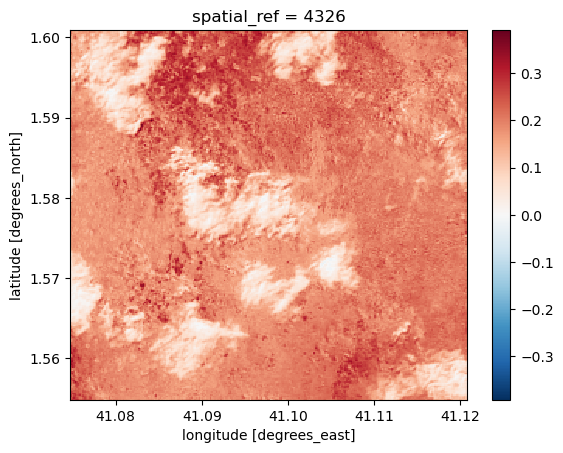

In [30]:
def ndvi(band_red, band_nir):
    return (band_nir - band_red) / (band_nir + band_red)

mc_float = mc.where(mc.B02 != 0, np.nan).dropna(dim='time', how='all')
ndvi(mc_float.B04.mean(dim='time'), mc_float.B8A.mean(dim='time')).plot.imshow()